In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
# Define constants
EPOCHS = 20
BATCH_SIZE = 64

In [2]:
# Define your transforms for the training and testing sets.  Must be normalized as follows for resnet50 model

transform =transforms.Compose([transforms.Resize((224,224)),
                               transforms.RandomRotation(45),
                               transforms.RandomHorizontalFlip(0.5),
                            #    transforms.GaussianBlur((3, 3), sigma=(0.1, 2.0)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder('dataset', transform=transform)

In [3]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# Use the GPU if available do not use cpu if gpu is not available simply fail fast
device = torch.device("cuda") 


In [5]:
# Split the data into training, testing, and validation sets
# 80% training, 10% testing, 10% validation
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)


In [6]:
from torch.utils.data import Dataset, DataLoader
# Create data loaders for the training, test, and validation sets
dataloaders = {
    "train": DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),
    "test": DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True),
    "val": DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
}

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

#the second argument of the last layer here is the number of classes you want
#the classifier to be able to classify
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 74)
)

In [8]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [9]:
# Move the model to the GPU, this will fail if the GPU is not available
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
import torch.optim as optim

# Define the loss function and optimizer
# CrossEntropyLoss is used for multi-class classification

criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


In [11]:
# set up metrics to keep track of the loss and accuracy
metrics = {
    'train': {
        'loss': [], 'accuracy': []
    },
    'val': {
        'loss': [], 'accuracy': []
    },
}

In [12]:
# Train the model for x epochs
# An epoch is one pass through the entire dataset
# The model is trained on the training set and evaluated on the validation set

for epoch in range(EPOCHS):
    ep_metrics = {
        'train': {'loss': 0, 'accuracy': 0, 'count': 0},
        'val': {'loss': 0, 'accuracy': 0, 'count': 0},
    }

    print(f'Epoch {epoch}')

    for phase in ['train', 'val']:
        print(f'------- {phase} --------')
        for images, labels in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(images.to(device))
                ohe_label = torch.nn.functional.one_hot(labels, num_classes=74)
                loss = criterion(output, ohe_label.float().to(device))
                correct_preds = labels.to(device) == torch.argmax(output, dim=1)
                accuracy = (correct_preds).sum()/len(labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
            
            ep_metrics[phase]['loss'] += loss.item()
            ep_metrics[phase]['accuracy'] += accuracy.item()
            ep_metrics[phase]['count'] += 1
        
        ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
        ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

        print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')
        metrics[phase]['loss'].append(ep_loss)
        metrics[phase]['accuracy'].append(ep_accuracy)
    # scheduler.step()

Epoch 0
------- train --------


/home/jeremiahkorreck/.conda/envs/pytorch2/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 3.975411827423993, Accuracy: 0.18464052291477429

------- val --------
Loss: 3.4009634364734995, Accuracy: 0.4390782822262157

Epoch 1
------- train --------
Loss: 2.598580513280981, Accuracy: 0.5382012528531691

------- val --------
Loss: 1.8898310552943836, Accuracy: 0.6541982347315008

Epoch 2
------- train --------
Loss: 1.4699362207861508, Accuracy: 0.6865400328355677

------- val --------
Loss: 1.2442445863376965, Accuracy: 0.7285353541374207

Epoch 3
------- train --------
Loss: 1.040384103971369, Accuracy: 0.7634940091301413

------- val --------
Loss: 1.0004944801330566, Accuracy: 0.726957071911205

Epoch 4
------- train --------
Loss: 0.8427151119007784, Accuracy: 0.7883782681296854

------- val --------
Loss: 0.8359445929527283, Accuracy: 0.7615214640443976

Epoch 5
------- train --------
Loss: 0.7286604229141684, Accuracy: 0.812091503423803

------- val --------
Loss: 0.8049238378351385, Accuracy: 0.7653093446384777

Epoch 6
------- train --------
Loss: 0.656916708805

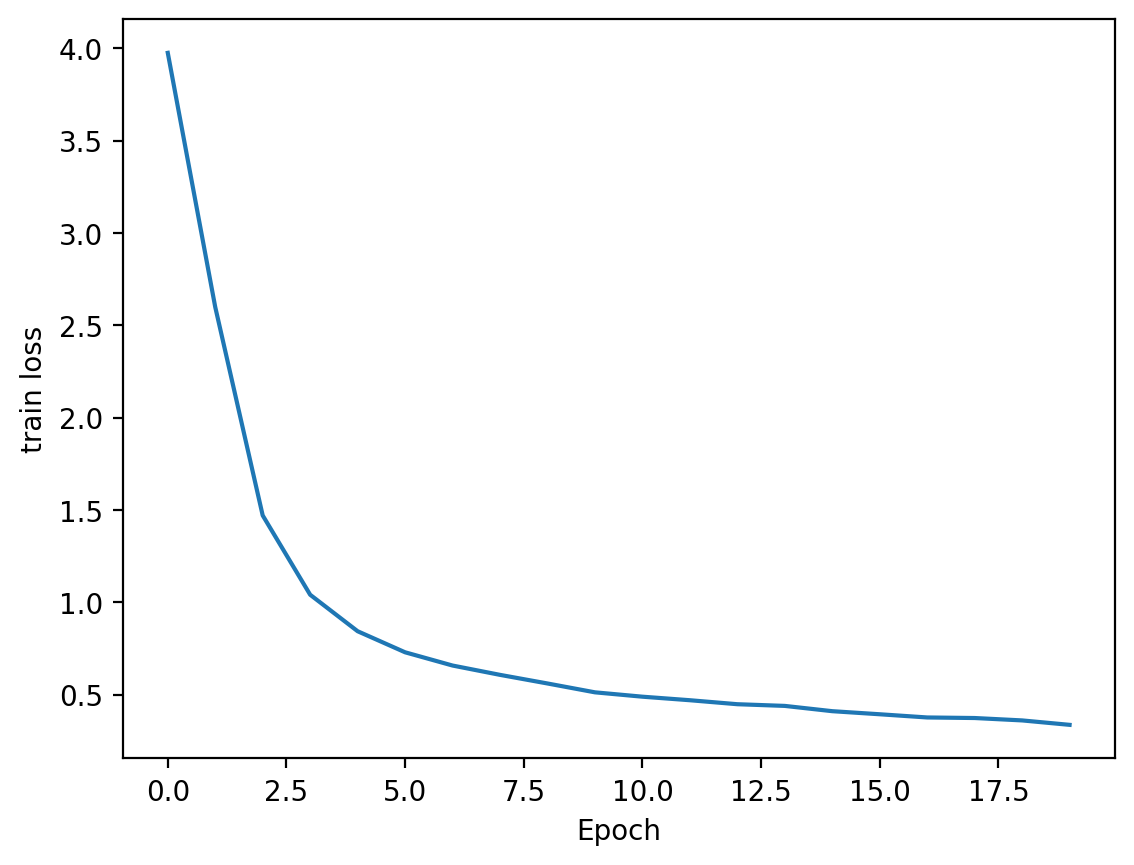

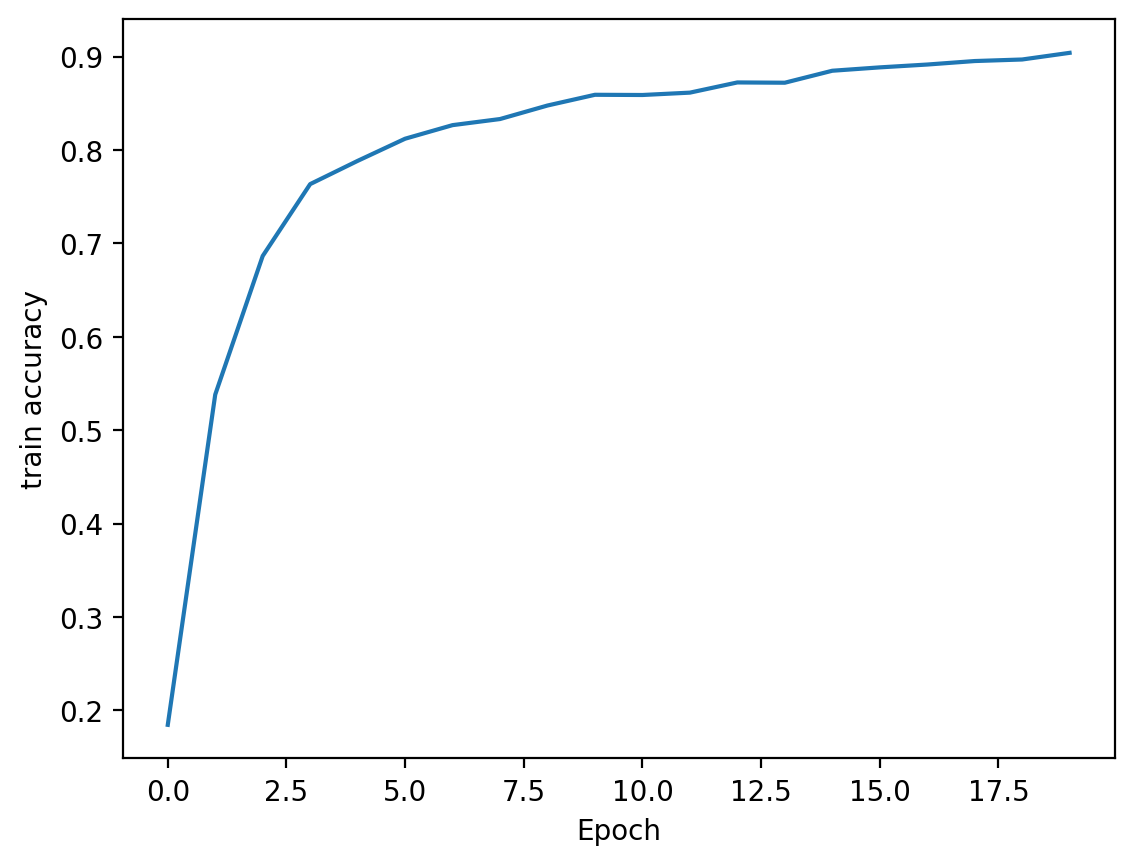

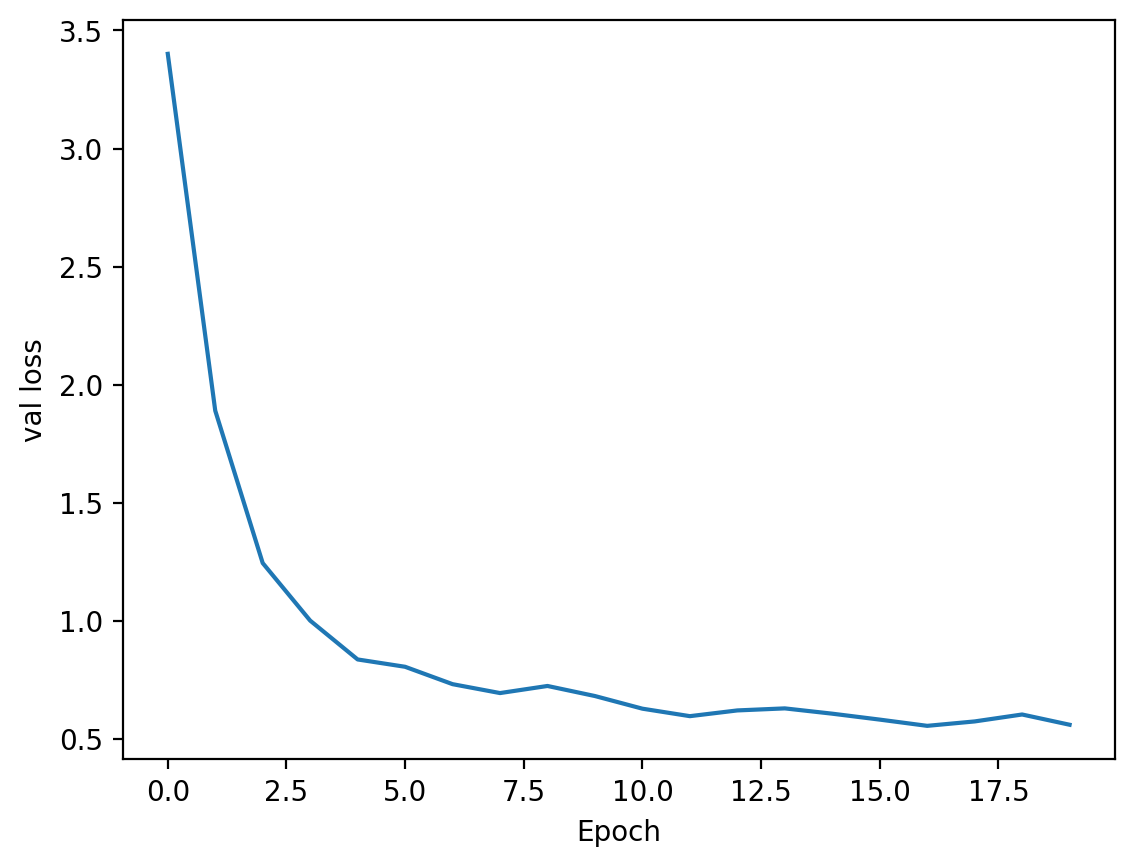

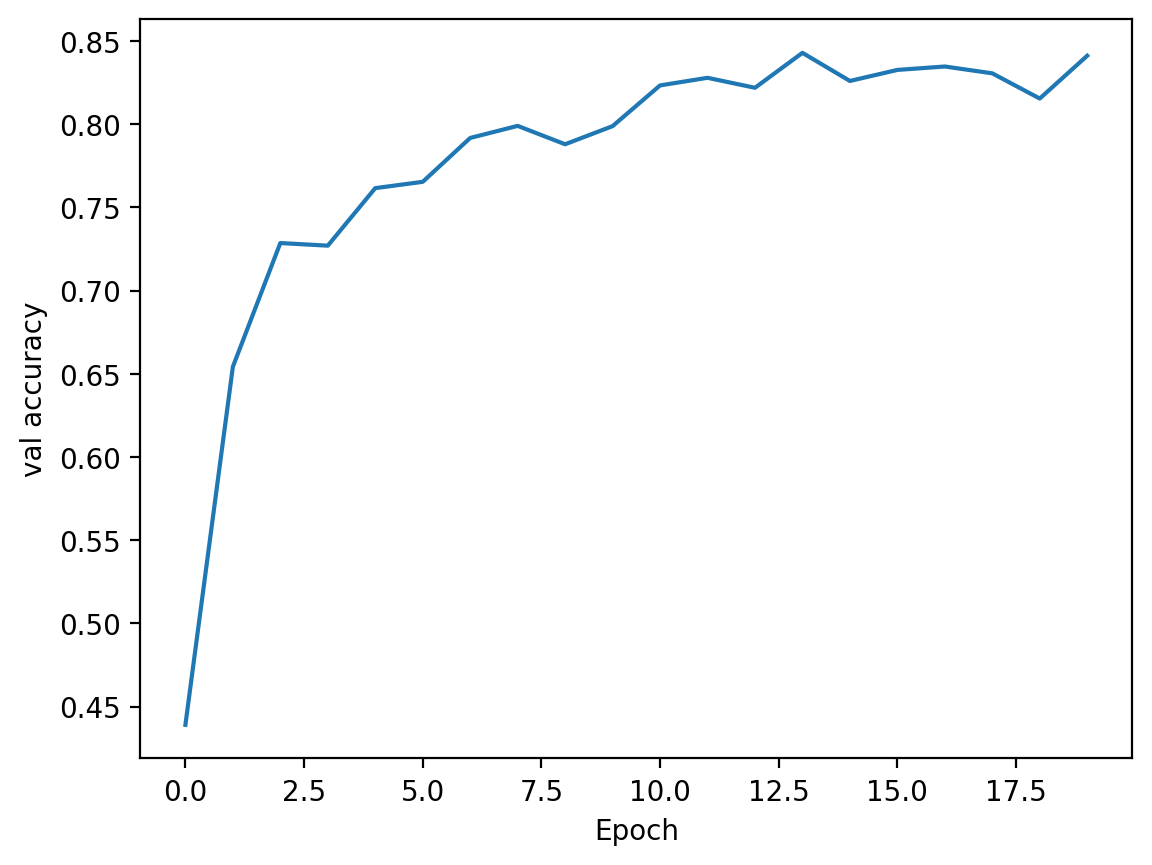

In [13]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

In [14]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in dataloaders['test']:
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=74)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")


Test Loss: 0.5318738222122192, Test Accuracy: 0.8449675440788269


In [15]:
saved_name = "dzmodel.pt"

torch.save(model.state_dict(), saved_name)


